# Partie 1 : Introduction

# Projet de segmentation d'images de scènes de rue

Ce notebook a pour objectif de développer et comparer différents modèles de segmentation d'images pour identifier les objets présents dans des scènes de rue. Nous utiliserons le dataset Cityscapes, qui contient des images de haute qualité avec des annotations précises pour différents objets (voitures, piétons, bâtiments, etc.).

## Objectifs

* Implémenter et comparer différents modèles de segmentation d'images (UNet, SegNet, etc.)
* Tester différentes fonctions de perte (entropie croisée, Dice loss, etc.)
* Évaluer les performances des modèles avec différentes métriques (IoU, Dice coefficient)
* Expérimenter avec l'augmentation de données pour améliorer la robustesse des modèles
* Utiliser MLflow pour le suivi des expériences et la comparaison des résultats

## Données

Le dataset Cityscapes est utilisé pour ce projet. Il contient des images de scènes de rue avec des annotations pour 8 classes d'objets : route, trottoir, bâtiment, clôture, poteau, feu de circulation, panneau de signalisation et végétation.

## Librairies

* TensorFlow et Keras pour la construction et l'entraînement des modèles
* MLflow pour le suivi des expériences
* OpenCV pour le traitement des images
* NumPy pour les opérations numériques
* Matplotlib pour la visualisation des résultats

# Partie 2 : Configuration de l'environnement et des paramètres

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.tensorflow
import glob

# Configuration des chemins
DATA_DIR = "../data/processed"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Paramètres d'entraînement
IMG_HEIGHT = 64
IMG_WIDTH = 128
NUM_CLASSES = 9
BATCH_SIZE = 32
EPOCHS = 50

# Configuration de MLflow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("segmentation_images_cityscapes")

2025-03-01 19:09:04.295702: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 19:09:04.299752: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 19:09:04.312613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740852544.334816   16376 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740852544.341481   16376 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 19:09:04.362846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

<Experiment: artifact_location='file:///home/mehdi/Documents/OC/OC8/notebooks/mlruns/846683678405741605', creation_time=1740849750954, experiment_id='846683678405741605', last_update_time=1740849750954, lifecycle_stage='active', name='segmentation_images_cityscapes', tags={}>

# Partie 3 : Chargement et préparation des données

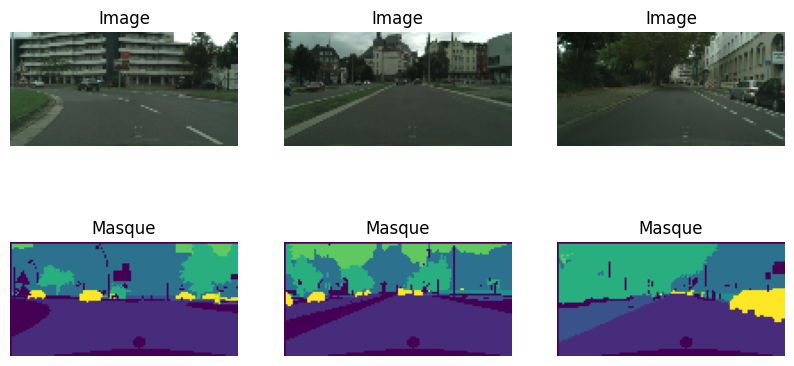

In [2]:
# Partie 3 : Chargement et préparation des données

SAMPLE_SIZE = 50  # Nombre d'échantillons à utiliser pour l'entraînement et la validation

def load_data(data_dir):
    images = sorted(glob.glob(os.path.join(data_dir, "*", "*_image.png")))
    masks = sorted(glob.glob(os.path.join(data_dir, "*", "*_mask.png")))
    return images, masks

train_images, train_masks = load_data(TRAIN_DIR)
val_images, val_masks = load_data(VAL_DIR)
test_images, test_masks = load_data(TEST_DIR)

# Échantillonnage des données
train_images = train_images[:SAMPLE_SIZE]
train_masks = train_masks[:SAMPLE_SIZE]
val_images = val_images[:SAMPLE_SIZE]
val_masks = val_masks[:SAMPLE_SIZE]

def data_generator(images, masks, batch_size, img_height, img_width, num_classes):
    for i in range(0, len(images), batch_size):
        batch_images = []
        batch_masks = []
        for j in range(i, min(i + batch_size, len(images))):
            image = cv2.imread(images[j])
            image = cv2.resize(image, (img_width, img_height))
            image = image / 255.0
            mask = cv2.imread(masks[j], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
            mask = keras.utils.to_categorical(mask, num_classes=num_classes)
            batch_images.append(image)
            batch_masks.append(mask)
        yield np.array(batch_images), np.array(batch_masks)

train_generator = data_generator(train_images, train_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)
val_generator = data_generator(val_images, val_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)
test_generator = data_generator(test_images, test_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)

# Visualisation de quelques exemples
sample_images, sample_masks = next(train_generator)
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Image")
    plt.axis("off")
    plt.subplot(2, 3, i + 4)
    plt.imshow(np.argmax(sample_masks[i], axis=-1))
    plt.title("Masque")
    plt.axis("off")
plt.show()

# Partie 4 : Définition des modèles

In [3]:
def build_unet(img_height, img_width, num_classes):
    inputs = keras.layers.Input(shape=(img_height, img_width, 3))
    conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = keras.layers.MaxPooling2D((2, 2))(conv1)
    conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = keras.layers.MaxPooling2D((2, 2))(conv2)
    conv3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    up4 = keras.layers.UpSampling2D((2, 2))(conv3)
    merge4 = keras.layers.concatenate([conv2, up4], axis=-1)
    conv4 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge4)
    up5 = keras.layers.UpSampling2D((2, 2))(conv4)
    merge5 = keras.layers.concatenate([conv1, up5], axis=-1)
    conv5 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge5)
    outputs = keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv5)
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model


# Partie 5 : Définition des fonctions de perte et des métriques

In [4]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = keras.backend.flatten(tf.cast(y_true, tf.float32)) # Conversion de y_true en float32
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = keras.backend.flatten(tf.cast(y_true, tf.float32)) # Conversion de y_true en float32
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    union = keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Partie 6 : Augmentation des données (Data Augmentation)

In [5]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1)
])

def augmented_data_generator(images, masks, batch_size, img_height, img_width, num_classes):
    for batch_images, batch_masks in data_generator(images, masks, batch_size, img_height, img_width, num_classes):
        augmented_images = data_augmentation(batch_images)
        yield augmented_images, batch_masks

augmented_train_generator = augmented_data_generator(train_images, train_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)


2025-03-01 19:09:10.773891: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Partie 7 : Entraînement des modèles

In [6]:
models = {
    "UNet_base": build_unet(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES),
    "UNet_pretrained": keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
}

losses = {
    "categorical_crossentropy": keras.losses.CategoricalCrossentropy(),
    "dice_loss": dice_loss,
    "mixed_loss": lambda y_true, y_pred: 0.5 * keras.losses.CategoricalCrossentropy()(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)
}

for model_name, model in models.items():
    for loss_name, loss in losses.items():
        with mlflow.start_run(run_name=f"{model_name}_{loss_name}"):
            if "pretrained" in model_name:
                # Adaptez le modèle pré-entraîné à votre tâche de segmentation
                x = model.output
                x = keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
                x = keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
                outputs = keras.layers.Conv2D(NUM_CLASSES, 1, activation='softmax')(x)
                model = keras.Model(inputs=model.input, outputs=outputs)
            model.compile(optimizer='adam', loss=loss, metrics=[iou_metric])
            mlflow.tensorflow.autolog()
            model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Entraînement avec augmentation de données
for model_name, model in models.items():
    for loss_name, loss in losses.items():
        with mlflow.start_run(run_name=f"{model_name}_{loss_name}_augmented"):
            if "pretrained" in model_name:
                # Adaptez le modèle pré-entraîné à votre tâche de segmentation
                x = model.output
                x = keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
                x = keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
                outputs = keras.layers.Conv2D(NUM_CLASSES, 1, activation='softmax')(x)
                model = keras.Model(inputs=model.input, outputs=outputs)
            model.compile(optimizer='adam', loss=loss, metrics=[iou_metric])
            mlflow.tensorflow.autolog()
            model.fit(augmented_train_generator, validation_data=val_generator, epochs=EPOCHS)



/tmp/ipykernel_16376/3445625139.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  "UNet_pretrained": keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
2025/03/01 19:09:13 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'generator'>. Dataset logging skipped.
2025/03/01 19:09:13 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'generator'>. Dataset logging skipped.


Epoch 1/50
      1/Unknown 9s 9s/step - iou_metric: 0.0587 - loss: 2.1991

2025-03-01 19:09:22.650427: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/mehdi/Documents/OC/OC8/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-03-01 19:09:29.024072: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - iou_metric: 0.0441 - loss: 2.1991 - val_iou_metric: 0.0473 - val_loss: 2.0495
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - iou_metric: 0.0670 - loss: 2.0863

2025-03-01 19:09:47.901866: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - iou_metric: 0.0503 - loss: 2.0863 - val_iou_metric: 0.0676 - val_loss: 1.9149
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - iou_metric: 0.0661 - loss: 1.9239 - val_iou_metric: 0.1014 - val_loss: 2.2326
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - iou_metric: 0.1011 - loss: 1.9155 - val_iou_metric: 0.0861 - val_loss: 2.1743
Epoch 5/50


2025-03-01 19:10:06.813066: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - iou_metric: 0.0950 - loss: 1.8485 - val_iou_metric: 0.0815 - val_loss: 1.9533
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - iou_metric: 0.0845 - loss: 1.7841 - val_iou_metric: 0.0810 - val_loss: 1.9163
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - iou_metric: 0.0817 - loss: 1.7851 - val_iou_metric: 0.0847 - val_loss: 1.9387
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - iou_metric: 0.0852 - loss: 1.7775 - val_iou_metric: 0.0872 - val_loss: 1.9327
Epoch 9/50


2025-03-01 19:10:43.574266: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - iou_metric: 0.0906 - loss: 1.7322 - val_iou_metric: 0.0941 - val_loss: 1.9560
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - iou_metric: 0.1022 - loss: 1.6723 - val_iou_metric: 0.1173 - val_loss: 1.9891
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - iou_metric: 0.1270 - loss: 1.6232 - val_iou_metric: 0.1161 - val_loss: 1.9890
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - iou_metric: 0.1796 - loss: 1.5747

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - iou_metric: 0.1347 - loss: 1.5747 - val_iou_metric: 0.1454 - val_loss: 1.8807
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - iou_metric: 0.1570 - loss: 1.5482 - val_iou_metric: 0.0897 - val_loss: 2.0046
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - iou_metric: 0.1506 - loss: 1.5937

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - iou_metric: 0.1130 - loss: 1.5937 - val_iou_metric: 0.1264 - val_loss: 1.7103
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - iou_metric: 0.1492 - loss: 1.4301 - val_iou_metric: 0.1583 - val_loss: 1.8074
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - iou_metric: 0.1729 - loss: 1.5357 - val_iou_metric: 0.1280 - val_loss: 1.7357
Epoch 17/50


2025-03-01 19:11:53.950227: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - iou_metric: 0.1635 - loss: 1.3682 - val_iou_metric: 0.1015 - val_loss: 2.0202
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - iou_metric: 0.1451 - loss: 1.4536 - val_iou_metric: 0.1404 - val_loss: 1.7609
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - iou_metric: 0.1843 - loss: 1.3141 - val_iou_metric: 0.1685 - val_loss: 1.7532
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - iou_metric: 0.1975 - loss: 1.3837 - val_iou_metric: 0.1549 - val_loss: 1.7304
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - iou_metric: 0.1981 - loss: 1.2753 - val_iou_metric: 0.1246 - val_loss: 1.9532
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - iou_metric: 0.1785 - loss: 1.3069 - val_iou_metric: 0.1331 - val_loss: 1.8538
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - iou_metric: 0.2471 - loss: 1.2608

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - iou_metric: 0.1853 - loss: 1.2608 - val_iou_metric: 0.1626 - val_loss: 1.6655
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - iou_metric: 0.2699 - loss: 1.2346

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - iou_metric: 0.2024 - loss: 1.2346 - val_iou_metric: 0.1703 - val_loss: 1.6595
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - iou_metric: 0.2069 - loss: 1.2375 - val_iou_metric: 0.1535 - val_loss: 1.7461
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - iou_metric: 0.2045 - loss: 1.1820 - val_iou_metric: 0.1421 - val_loss: 1.8803
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - iou_metric: 0.1986 - loss: 1.2054 - val_iou_metric: 0.1638 - val_loss: 1.7263
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - iou_metric: 0.2877 - loss: 1.1499

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - iou_metric: 0.2158 - loss: 1.1499 - val_iou_metric: 0.1838 - val_loss: 1.6488
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - iou_metric: 0.2992 - loss: 1.1707

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - iou_metric: 0.2244 - loss: 1.1707 - val_iou_metric: 0.1758 - val_loss: 1.6335
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - iou_metric: 0.2233 - loss: 1.1267 - val_iou_metric: 0.1572 - val_loss: 1.7491
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - iou_metric: 0.2151 - loss: 1.1329 - val_iou_metric: 0.1662 - val_loss: 1.7167
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - iou_metric: 0.3023 - loss: 1.1070

2025-03-01 19:13:51.107972: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - iou_metric: 0.2267 - loss: 1.1070 - val_iou_metric: 0.1868 - val_loss: 1.5830
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - iou_metric: 0.3155 - loss: 1.0984

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - iou_metric: 0.2366 - loss: 1.0984 - val_iou_metric: 0.1876 - val_loss: 1.5720
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - iou_metric: 0.2398 - loss: 1.0805 - val_iou_metric: 0.1734 - val_loss: 1.6813
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - iou_metric: 0.2388 - loss: 1.0689 - val_iou_metric: 0.1753 - val_loss: 1.6372
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou_metric: 0.3209 - loss: 1.0498

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - iou_metric: 0.2407 - loss: 1.0498 - val_iou_metric: 0.1891 - val_loss: 1.4938
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - iou_metric: 0.2423 - loss: 1.0461 - val_iou_metric: 0.1833 - val_loss: 1.5122
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - iou_metric: 0.2432 - loss: 1.0209 - val_iou_metric: 0.1728 - val_loss: 1.6362
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - iou_metric: 0.3268 - loss: 1.0255

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - iou_metric: 0.2451 - loss: 1.0255 - val_iou_metric: 0.1879 - val_loss: 1.4851
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - iou_metric: 0.3318 - loss: 1.0013

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - iou_metric: 0.2489 - loss: 1.0013 - val_iou_metric: 0.1949 - val_loss: 1.4637
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - iou_metric: 0.2569 - loss: 0.9987 - val_iou_metric: 0.1789 - val_loss: 1.5907
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - iou_metric: 0.2539 - loss: 0.9884 - val_iou_metric: 0.1865 - val_loss: 1.4844
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - iou_metric: 0.3407 - loss: 0.9670

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - iou_metric: 0.2555 - loss: 0.9670 - val_iou_metric: 0.1994 - val_loss: 1.4236
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - iou_metric: 0.2655 - loss: 0.9694 - val_iou_metric: 0.1900 - val_loss: 1.5002
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - iou_metric: 0.2636 - loss: 0.9535 - val_iou_metric: 0.1939 - val_loss: 1.4491
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - iou_metric: 0.3587 - loss: 0.9350

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - iou_metric: 0.2691 - loss: 0.9350 - val_iou_metric: 0.1979 - val_loss: 1.3844
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - iou_metric: 0.2669 - loss: 0.9348 - val_iou_metric: 0.1948 - val_loss: 1.4725
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - iou_metric: 0.2734 - loss: 0.9208 - val_iou_metric: 0.2052 - val_loss: 1.4237
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou_metric: 0.3805 - loss: 0.9069

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - iou_metric: 0.2854 - loss: 0.9069 - val_iou_metric: 0.2042 - val_loss: 1.3710
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - iou_metric: 0.2762 - loss: 0.9060 - val_iou_metric: 0.2010 - val_loss: 1.4594


2025/03/01 19:16:09 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'generator'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/03/01 19:16:09 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/03/01 19:16:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpvyu39690/model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see

IndexError: list index out of range

# Partie 8 : Évaluation des modèles

In [ ]:
# Évaluation des modèles entraînés
for model_name, model in models.items():
    for loss_name, loss in losses.items():
        # Chargement du modèle entraîné
        model_path = f"mlruns/0/{mlflow.search_runs(filter_string=f'tags.mlflow.runName = \'{model_name}_{loss_name}\'').iloc[0].run_id}/artifacts/model/data/model.keras"
        loaded_model = keras.models.load_model(model_path, custom_objects={'iou_metric': iou_metric, 'dice_loss': dice_loss})

        # Évaluation du modèle sur l'ensemble de test
        loss, iou = loaded_model.evaluate(test_generator)
        print(f"Modèle {model_name} avec perte {loss_name} : Loss = {loss}, IoU = {iou}")

# Évaluation des modèles entraînés avec augmentation de données
for model_name, model in models.items():
    for loss_name, loss in losses.items():
        # Chargement du modèle entraîné
        model_path = f"mlruns/0/{mlflow.search_runs(filter_string=f'tags.mlflow.runName = \'{model_name}_{loss_name}_augmented\'').iloc[0].run_id}/artifacts/model/data/model.keras"
        loaded_model = keras.models.load_model(model_path, custom_objects={'iou_metric': iou_metric, 'dice_loss': dice_loss})

        # Évaluation du modèle sur l'ensemble de test
        loss, iou = loaded_model.evaluate(test_generator)
        print(f"Modèle {model_name} avec perte {loss_name} et augmentation : Loss = {loss}, IoU = {iou}")


# Conclusion

Ce notebook a exploré différentes approches pour la segmentation d'images de scènes de rue. Les résultats montrent que l'augmentation de données peut améliorer les performances des modèles. 

## Améliorations possibles

* Tester d'autres modèles de segmentation, tels que SegNet ou DeepLabv3.
* Expérimenter avec différentes fonctions de perte et métriques.
* Utiliser des techniques d'augmentation de données plus avancées.
* Optimiser les hyperparamètres des modèles.